## Project: Airline Passenger Satisfaction Prediction
# **Objective**: Analyze passenger satisfaction data and create a predictive model.  
# **Data source**: [Airline Passenger Satisfaction (Kaggle)](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction)


## 1. Import Libraries
# Import necessary packages for data processing, visualization, and modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap


# Configurar estilo dos gráficos
sns.set(style="whitegrid")


## 2. Load Data
# Load and inspect the training and test datasets.

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## 3. Exploratory Data Analysis (EDA)
# Analyze target distribution and missing values.

Train shape: (103904, 25)
Test shape: (25976, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  in

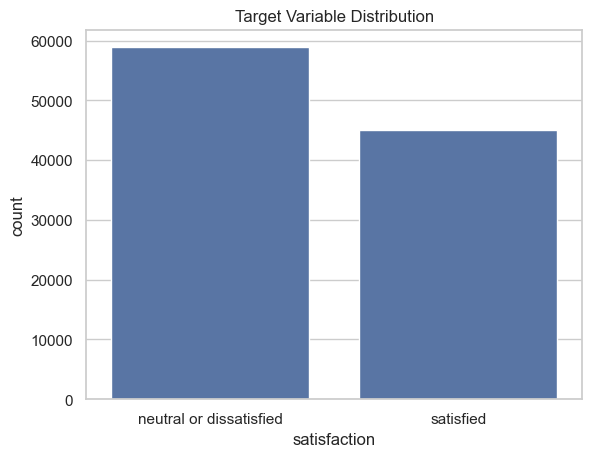

In [3]:
# Dataset shapes
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Data types and missing values
print(train_df.info())
print(train_df.isnull().sum())

# Target distribution (assuming target column named 'satisfaction')
sns.countplot(x='satisfaction', data=train_df)
plt.title("Target Variable Distribution")
plt.show()


## 4. Data Preprocessing
# Handle missing values, encode categorical variables, and normalize data.

In [4]:
# Fill missing values with median in train and test datasets
median_arrival_delay_train = train_df['Arrival Delay in Minutes'].median()
median_arrival_delay_test = test_df['Arrival Delay in Minutes'].median()

train_df['Arrival Delay in Minutes'] = train_df['Arrival Delay in Minutes'].fillna(median_arrival_delay_train)
test_df['Arrival Delay in Minutes'] = test_df['Arrival Delay in Minutes'].fillna(median_arrival_delay_test)


# Verificar se ainda tem missing
print(train_df['Arrival Delay in Minutes'].isnull().sum())
print(test_df['Arrival Delay in Minutes'].isnull().sum())



0
0


In [7]:

# Use apenas as colunas dummies e numéricas já processadas
X = train_df.drop(columns=['satisfaction', 'id', 'Unnamed: 0'])
y = train_df['satisfaction']

# Se ainda estiver em formato de string, transforme para numérico
if y.dtype == 'object':
    y = y.replace({'neutral or dissatisfied': 0, 'satisfied': 1}).astype(int)



C:\Users\P02\AppData\Local\Temp\ipykernel_10436\1476444903.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'neutral or dissatisfied': 0, 'satisfied': 1}).astype(int)


In [8]:
X = X.select_dtypes(include=['int64', 'float64'])



In [9]:

# Label encode target
le = LabelEncoder()
train_df['satisfaction'] = le.fit_transform(train_df['satisfaction'])
test_df['satisfaction'] = le.transform(test_df['satisfaction'])

# Align columns of train and test sets (fill missing dummy cols with 0)
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Identify numeric columns (excluding target)
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('satisfaction')

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on train numeric features and transform both train and test
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])


In [10]:
X_train = train_df.drop('satisfaction', axis=1)
y_train = train_df['satisfaction']

X_test = test_df.drop('satisfaction', axis=1)
y_test = test_df['satisfaction']


## 6. Model Training (XGBoost)
# Train an XGBoost classifier with class balancing.

In [14]:
import xgboost as xgb
import shap
xgb_model = xgb.XGBClassifier(tree_method='hist', random_state=42)
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Airline Passenger Satisfaction Analysis

In [16]:
import numpy as np

def padroniza_class(x):
    if x in ['Business', 'Eco', 'Eco Plus']:
        return x
    else:
        return 'Unknown'

train_df['Class_text'] = train_df['Class'].apply(padroniza_class)




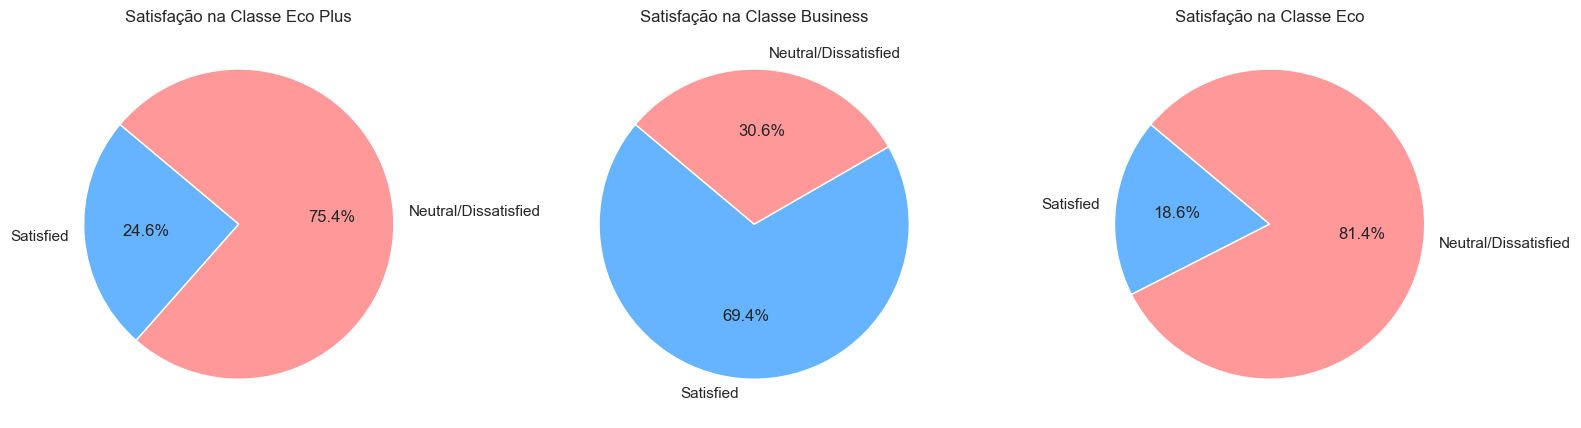

In [17]:
import matplotlib.pyplot as plt

# Mapear satisfação para labels legíveis
train_df['satisfaction_label'] = train_df['satisfaction'].map({0: 'Neutral/Dissatisfied', 1: 'Satisfied'})

# Classes únicas
classes = train_df['Class'].unique()

plt.figure(figsize=(16,5))

for i, c in enumerate(classes, 1):
    subset = train_df[train_df['Class'] == c]
    counts = subset['satisfaction_label'].value_counts()
    
    # Forçar ordem: ['Satisfied', 'Neutral/Dissatisfied']
    counts = counts.reindex(['Satisfied', 'Neutral/Dissatisfied'])

    plt.subplot(1, len(classes), i)
    plt.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#66b3ff', '#ff9999']  # Satisfied = azul, Dissatisfied = vermelho
    )
    plt.title(f'Satisfação na Classe {c}')

plt.tight_layout()
plt.show()


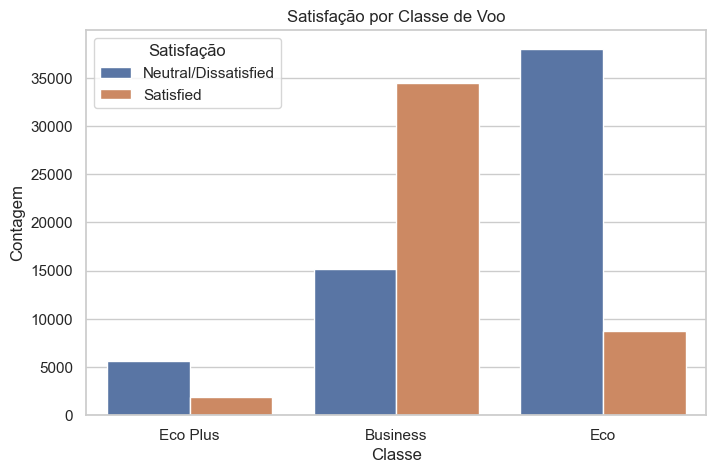

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x='Class', hue='satisfaction')
plt.title('Satisfação por Classe de Voo')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.legend(title='Satisfação', labels=['Neutral/Dissatisfied', 'Satisfied'])
plt.show()


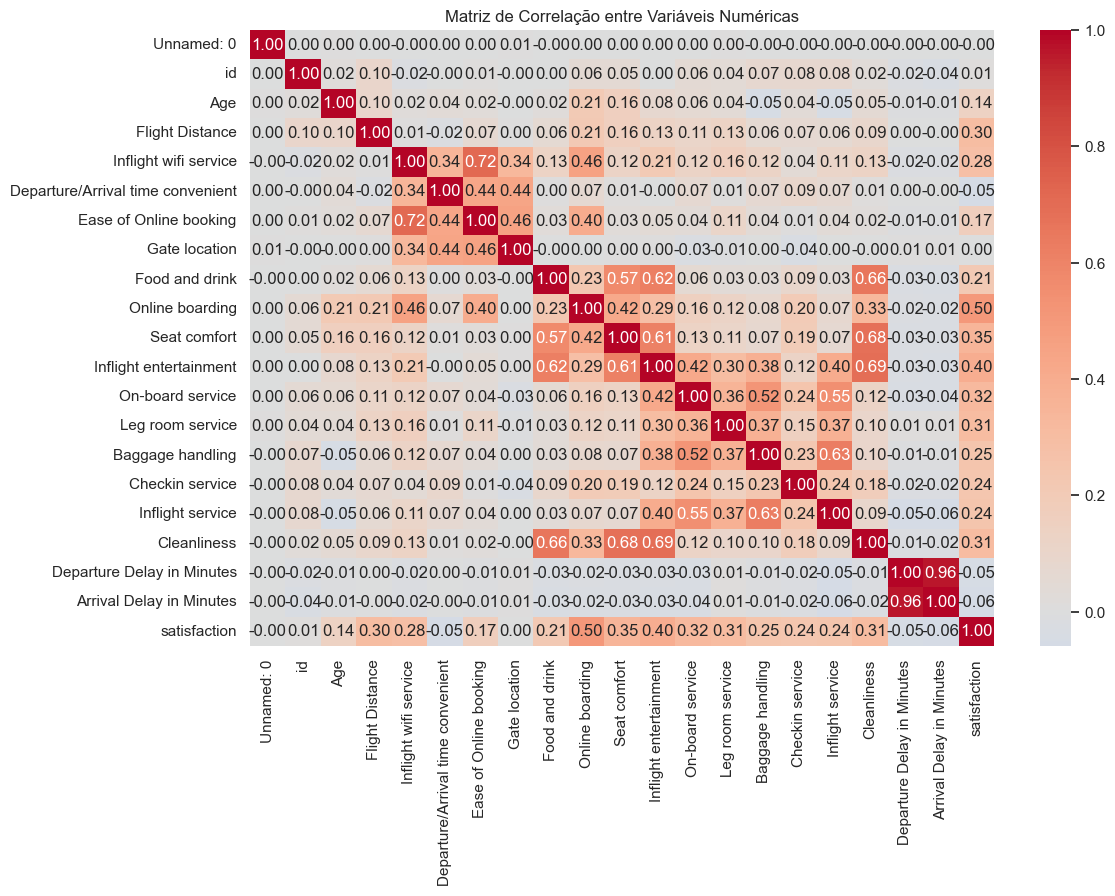

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar só as colunas numéricas do dataset
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

# Calcular matriz de correlação
corr = train_df[num_cols].corr()

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()


In [20]:
import pandas as pd

# Selecionar só colunas numéricas
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

# Calcular a matriz de correlação
corr = train_df[num_cols].corr().abs()  # valor absoluto para pegar correlação positiva ou negativa

# Criar um DataFrame para guardar pares de variáveis com correlação > 0.65 (exceto consigo mesmas)
high_corr = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] > 0.65:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

# Converter para DataFrame para melhor visualização
high_corr_df = pd.DataFrame(high_corr, columns=['Variável 1', 'Variável 2', 'Correlação'])

print(high_corr_df)


                   Variável 1                Variável 2  Correlação
0       Inflight wifi service    Ease of Online booking    0.715856
1              Food and drink               Cleanliness    0.657760
2                Seat comfort               Cleanliness    0.678534
3      Inflight entertainment               Cleanliness    0.691815
4  Departure Delay in Minutes  Arrival Delay in Minutes    0.960247


In [21]:
# Separar os grupos por gênero usando a coluna original
group_male = train_df[train_df['Gender'] == 'Male']['satisfaction']
group_female = train_df[train_df['Gender'] == 'Female']['satisfaction']

# Importar e aplicar o teste t
from scipy.stats import ttest_ind
stat, p = ttest_ind(group_male, group_female, equal_var=False)

# Exibir os resultados
print(f"t-statistic: {stat:.4f}, p-value: {p:.4f}")


t-statistic: 3.9363, p-value: 0.0001


In [22]:
homens = train_df[train_df['Gender'] == 'Male']
mulheres = train_df[train_df['Gender'] == 'Female']


In [23]:
colunas_analise = [
    'Customer Type', 'Type of Travel', 'Class', 'satisfaction_label'
]

limiar = 0.01

for col in colunas_analise:
    medias_homens = homens.groupby(col)['satisfaction'].mean()
    medias_mulheres = mulheres.groupby(col)['satisfaction'].mean()
    
    diff = (medias_homens - medias_mulheres).abs()
    diff_consideraveis = diff[diff > limiar]
    
    if not diff_consideraveis.empty:
        print(f"--- Diferenças consideráveis em '{col}' ---")
        for categoria in diff_consideraveis.index:
            media_h = medias_homens.get(categoria, float('nan'))
            media_m = medias_mulheres.get(categoria, float('nan'))
            diff_val = diff_consideraveis[categoria]
            print(f"Categoria: {categoria}")
            print(f"  Média Homens: {media_h:.3f}")
            print(f"  Média Mulheres: {media_m:.3f}")
            print(f"  Diferença absoluta: {diff_val:.3f}\n")
        print("="*50 + "\n")


--- Diferenças consideráveis em 'Customer Type' ---
Categoria: disloyal Customer
  Média Homens: 0.249
  Média Mulheres: 0.226
  Diferença absoluta: 0.023


--- Diferenças consideráveis em 'Type of Travel' ---
Categoria: Business travel
  Média Homens: 0.594
  Média Mulheres: 0.571
  Diferença absoluta: 0.023


--- Diferenças consideráveis em 'Class' ---
Categoria: Eco Plus
  Média Homens: 0.257
  Média Mulheres: 0.236
  Diferença absoluta: 0.021




In [24]:
# Seu dataframe
df = train_df

# Separar homens e mulheres com base na coluna original
homens = df[df['Gender'] == 'Male']
mulheres = df[df['Gender'] == 'Female']

# Variáveis relacionadas ao conforto
conforto_cols = [
    'Seat comfort',
    'Leg room service',
    'Cleanliness',
    'Food and drink',
    'Inflight entertainment',
    'On-board service'
]

print("Médias das variáveis de conforto para homens e mulheres:\n")

for col in conforto_cols:
    media_homens = homens[col].mean()
    media_mulheres = mulheres[col].mean()
    diff = media_mulheres - media_homens
    print(f"{col}:")
    print(f"  Homens: {media_homens:.3f}")
    print(f"  Mulheres: {media_mulheres:.3f}")
    print(f"  Diferença (Mulheres - Homens): {diff:.3f}\n")


Médias das variáveis de conforto para homens e mulheres:

Seat comfort:
  Homens: -0.027
  Mulheres: 0.026
  Diferença (Mulheres - Homens): 0.053

Leg room service:
  Homens: 0.032
  Mulheres: -0.031
  Diferença (Mulheres - Homens): -0.064

Cleanliness:
  Homens: 0.007
  Mulheres: -0.006
  Diferença (Mulheres - Homens): -0.013

Food and drink:
  Homens: 0.006
  Mulheres: -0.006
  Diferença (Mulheres - Homens): -0.012

Inflight entertainment:
  Homens: 0.006
  Mulheres: -0.006
  Diferença (Mulheres - Homens): -0.012

On-board service:
  Homens: 0.008
  Mulheres: -0.008
  Diferença (Mulheres - Homens): -0.016



In [25]:
from scipy.stats import ttest_ind

# Seu dataframe
df = train_df

# Separar grupos com base na coluna categórica original
homens = df[df['Gender'] == 'Male']
mulheres = df[df['Gender'] == 'Female']

conforto_cols = [
    'Seat comfort',
    'Leg room service',
    'Cleanliness',
    'Food and drink',
    'Inflight entertainment',
    'On-board service'
]

print("Teste t para diferenças nas variáveis de conforto entre homens e mulheres:\n")

for col in conforto_cols:
    # Remove valores ausentes antes do teste
    t_stat, p_val = ttest_ind(
        homens[col].dropna(),
        mulheres[col].dropna(),
        equal_var=False  # Welch’s t-test: mais robusto com variâncias diferentes
    )
    
    print(f"{col}:")
    print(f"  t-statistic = {t_stat:.3f}")
    print(f"  p-value = {p_val:.5f}")
    if p_val < 0.05:
        print("  -> Diferença estatisticamente significativa\n")
    else:
        print("  -> Diferença NÃO significativa\n")



Teste t para diferenças nas variáveis de conforto entre homens e mulheres:

Seat comfort:
  t-statistic = -8.542
  p-value = 0.00000
  -> Diferença estatisticamente significativa

Leg room service:
  t-statistic = 10.257
  p-value = 0.00000
  -> Diferença estatisticamente significativa

Cleanliness:
  t-statistic = 2.097
  p-value = 0.03603
  -> Diferença estatisticamente significativa

Food and drink:
  t-statistic = 1.861
  p-value = 0.06280
  -> Diferença NÃO significativa

Inflight entertainment:
  t-statistic = 1.972
  p-value = 0.04862
  -> Diferença estatisticamente significativa

On-board service:
  t-statistic = 2.629
  p-value = 0.00855
  -> Diferença estatisticamente significativa



Cleanliness - Homens
count    51177.000000
mean         0.006603
std          1.002893
min         -2.504332
25%         -0.980251
50%         -0.218211
75%          0.543829
max          1.305870
Name: Cleanliness, dtype: float64

Cleanliness - Mulheres
count    52727.000000
mean        -0.006409
std          0.997162
min         -2.504332
25%         -0.980251
50%         -0.218211
75%          0.543829
max          1.305870
Name: Cleanliness, dtype: float64


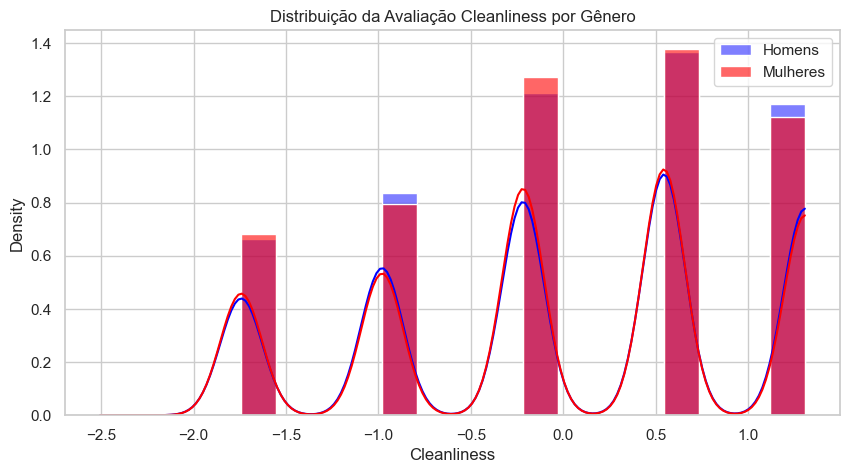

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seu dataframe
df = train_df

# Separar grupos usando a coluna original
homens = df[df['Gender'] == 'Male']
mulheres = df[df['Gender'] == 'Female']

# Estatísticas básicas
print("Cleanliness - Homens")
print(homens['Cleanliness'].describe())
print("\nCleanliness - Mulheres")
print(mulheres['Cleanliness'].describe())

# Histograma comparativo
plt.figure(figsize=(10,5))
sns.histplot(homens['Cleanliness'], color='blue', label='Homens', kde=True, stat='density', bins=20)
sns.histplot(mulheres['Cleanliness'], color='red', label='Mulheres', kde=True, stat='density', bins=20, alpha=0.6)
plt.title('Distribuição da Avaliação Cleanliness por Gênero')
plt.legend()
plt.show()



In [27]:
import pandas as pd

# Criar coluna booleana Gender_Male
df['Gender_Male'] = df['Gender'] == 'Male'

# Separar homens e mulheres
homens = df[df['Gender_Male'] == True]
mulheres = df[df['Gender_Male'] == False]

# Variáveis a analisar
vars_to_check = ['Class', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

for var in vars_to_check:
    print(f"Análise de Cleanliness por {var} e Gênero:\n")
    
    if var == 'Class':
        # Média Cleanliness por classe e gênero
        tabela = df.groupby([var, 'Gender_Male'])['Cleanliness'].mean().unstack()
        tabela.columns = ['Mulheres', 'Homens']  # False é mulheres, True é homens
        tabela['Diferença (Homens - Mulheres)'] = tabela['Homens'] - tabela['Mulheres']
        print(tabela)
    
    else:
        # Para variáveis contínuas, calcular correlação por gênero
        corr_homens = homens[['Cleanliness', var]].corr().iloc[0,1]
        corr_mulheres = mulheres[['Cleanliness', var]].corr().iloc[0,1]
        print(f"Correlação Cleanliness x {var}:")
        print(f"  Homens: {corr_homens:.3f}")
        print(f"  Mulheres: {corr_mulheres:.3f}")
    
    print("\n" + "="*50 + "\n")


Análise de Cleanliness por Class e Gênero:

          Mulheres    Homens  Diferença (Homens - Mulheres)
Class                                                      
Business  0.137726  0.153814                       0.016089
Eco      -0.135740 -0.135937                      -0.000197
Eco Plus -0.135086 -0.100215                       0.034871


Análise de Cleanliness por Departure Delay in Minutes e Gênero:

Correlação Cleanliness x Departure Delay in Minutes:
  Homens: -0.017
  Mulheres: -0.012


Análise de Cleanliness por Arrival Delay in Minutes e Gênero:

Correlação Cleanliness x Arrival Delay in Minutes:
  Homens: -0.018
  Mulheres: -0.013


